## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

In [ ]:
DATASETS_FOLDER = "C:/Users/Killian/Desktop/FYP-Multistage-Throughput-Predictor/Datasets/Final_Outputs/"
IMAGES_OUTPUT_FOLDER = "C:/Users/Killian/Desktop/FYP-Multistage-Throughput-Predictor/Own Papers/Undergraduate Paper/Images/"

## Defining Analysis Functions

In [77]:
def import_data(model_name="univariate_baseline", just_preds=False, mb=True):
    if just_preds:
        predicted = np.load(DATASETS_FOLDER+model_name+"_predicted_y.npy")
        if mb:
            return predicted/1024
        return predicted
    true = np.squeeze(np.load(DATASETS_FOLDER+model_name+"_true_y.npy"))
    predicted = np.load(DATASETS_FOLDER+model_name+"_predicted_y.npy")
    if mb:
        return true/1024, predicted/1024
    return true, predicted

In [ ]:
def get_variance(data):
    return np.var(data)

In [ ]:
def get_std(data):
    return np.std(data)

In [78]:
def get_ts_residuals(true, pred):
        residuals = true-pred
        return residuals

In [58]:
import seaborn as sns
def time_step_boxplots(residuals=[], model_names=[], title="", xlim=(), savefig_path="", xlab="Residuals (Mbps)",showfliers = True):
    df = pd.DataFrame()
    for model, residuals in zip(model_names, residuals):
        for i in range(residuals.shape[1]):
            temp_df = pd.DataFrame()
            temp_df[xlab] = residuals[:,i]
            temp_df["Horizon (seconds)"] = i+1
            temp_df["Model"] = model
            df = pd.concat([df, temp_df])
    sns.set_theme(style="whitegrid")
    if showfliers:
        box = sns.boxplot(x=xlab, y="Horizon (seconds)",
                    hue="Model",
                    data=df, orient="h", whis=(5,95), saturation=1, flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'pink'})
    else:
        box = sns.boxplot(x=xlab, y="Horizon (seconds)",
            hue="Model",
            data=df, orient="h", whis=(5,95), saturation=1, showfliers=False)
    if xlim:
        box.set_xlim(xlim)
    box.set_title(title)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    # box.set_ylabel("Horizon (seconds)")
    if savefig_path:
        plt.savefig(savefig_path, dpi=300, bbox_inches='tight')
    plt.show() # Display the plot on the screen
    

In [81]:
def get_mape(true, predicted, epsilon=50/1024):
    denominator = np.squeeze(true) + epsilon
    try:
        mape = np.mean(np.abs((np.squeeze(true) - predicted)/denominator))*100
    except Exception as e:
        print(e)
        mape = "n/a"
    return mape

In [82]:
def get_ape(true, predicted, epsilon=50/1024):
    denominator = np.squeeze(true) + epsilon
    try:
        ape = np.abs((np.squeeze(true) - predicted)/denominator)*100
    except Exception as e:
        print(e)
        ape = "n/a"
    return ape

In [ ]:
def get_mse(true, predicted):
    mse = np.mean(np.power(np.squeeze(true)-predicted, 2))
    return mse

In [ ]:
def get_mae(true, predicted):
    mae = np.mean(np.abs(np.squeeze(true)-predicted))
    return mae

In [84]:
def create_latex_table(table):
    latex_string = "\\begin{table}[!htb]\n\\centering\n\\begin{tabular}{|c|c|c|c|c|c|}\n\\hline\n{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\\\\n\\hline\n"
    for row in table:
        for i in range(len(row)):
            if i == len(row) - 1:
                latex_string += str(row[i]) + "\\\\\n\\hline\n"
            else:
                latex_string += str(row[i]) + " & "
    latex_string_end = "\\end{tabular}\n\\label{tab:train_test_dist}\n\\end{table}"
    latex_string = latex_string + latex_string_end
    print(latex_string)

In [79]:
def carry_out_analysis(prefix="univariate", title_prefix="Univariate"):
    for dataset in ["low", "medium", "high", 1]:
        if dataset == 1:
            base_true, base_pred = import_data(model_name="{}_baseline".format(prefix))
            multiOne_true, multiOne_pred = import_data(model_name="{}_multiOne".format(prefix))
            multiAll_true, multiAll_pred = import_data(model_name="{}_multiAll".format(prefix))

            # Get Residuals
            base_resids = get_ts_residuals(base_true, base_pred)
            multiOne_resids = get_ts_residuals(multiOne_true, multiOne_pred)
            multiAll_resids = get_ts_residuals(multiAll_true, multiAll_pred)

            # Get Absolute Percent Error
            base_ape = get_ape(base_true, base_pred)
            multiOne_ape = get_ape(multiOne_true, multiOne_pred)
            multiAll_ape = get_ape(multiAll_true, multiAll_pred)
            
            # Boxplot of residuals
            time_step_boxplots(residuals=[base_resids, multiOne_resids, multiAll_resids],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Model Performance on All Test Sequences",
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"{} On All Test Data".format(title_prefix))
            
            # Boxplot of Absolute Percent Error
            time_step_boxplots(residuals=[base_ape, multiOne_ape, multiAll_ape],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Absolute Percent Error on All Test Sequences",
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"APE of {} On All Test Data".format(title_prefix), xlab="Absolute Percent Error")
            
            # Boxplot of residuals No outliers
            time_step_boxplots(residuals=[base_resids, multiOne_resids, multiAll_resids],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Model Performance on All Test Sequences",
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"{} On All Test Data no Outliers".format(title_prefix), showfliers = False)
            
            # Boxplot of Absolute Percent Error no Outliers
            time_step_boxplots(residuals=[base_ape, multiOne_ape, multiAll_ape],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Absolute Percent Error on All Test Sequences",
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"APE of {} On All Test Data no Outliers".format(title_prefix), xlab="Absolute Percent Error", showfliers = False)


            # Standard Dev
            base_std = get_std(base_resids)
            multiOne_std = get_std(multiOne_resids)
            multiAll_std = get_std(multiAll_resids)

            # MAPE
            base_mape = get_mape(base_true, base_pred)
            multiOne_mape = get_mape(multiOne_true, multiOne_pred)
            multiAll_mape = get_mape(multiAll_true, multiAll_pred)

            # MSE
            base_mse = get_mse(base_true, base_pred)
            multiOne_mse = get_mse(multiOne_true, multiOne_pred)
            multiAll_mse = get_mse(multiAll_true, multiAll_pred)

            # MAE
            base_mae = get_mae(base_true, base_pred)
            multiOne_mae = get_mae(multiOne_true, multiOne_pred)
            multiAll_mae = get_mae(multiAll_true, multiAll_pred)

            # Table of metrics
            table = PrettyTable(["Model", "Mean Resids (Mbps)", " Resids std (Mbps)", "MAPE", "MSE", "MAE"])
            table.add_row(["Baseline",np.mean(base_resids), base_std, base_mape, base_mse, base_mae])
            table.add_row(["Multistage One",np.mean(multiOne_resids), multiOne_std, multiOne_mape, multiOne_mse, multiOne_mae])
            table.add_row(["Multistage All",np.mean(multiAll_resids), multiAll_std, multiAll_mape, multiAll_mse, multiAll_mae])
            print("Residuals of All Sequences Test Set")
            #print(table)
            raw_table = []
            raw_table.append(["Baseline",round(np.mean(base_resids),3), round(base_std,3), round(base_mape,3), round(base_mse,3), round(base_mae,3)])
            raw_table.append(["Multistage One",round(np.mean(multiOne_resids),3), round(multiOne_std,3), round(multiOne_mape,3), round(multiOne_mse,3), round(multiOne_mae,3)])
            raw_table.append(["Multistage All",round(np.mean(multiAll_resids),3), round(multiAll_std,3), round(multiAll_mape,3), round(multiAll_mse,3), round(multiAll_mae,3)])
            create_latex_table(raw_table)
        else:
            base_true, base_pred = import_data(model_name="{}_baseline_{}".format(prefix, dataset))
            single_true, single_pred = import_data(model_name="{}_multiOne_{}".format(prefix, dataset))

            # Get Residuals
            base_resids = get_ts_residuals(base_true, base_pred)
            single_resids = get_ts_residuals(single_true, single_pred)

            # Get APE
            base_ape = get_ape(base_true, base_pred)
            single_ape = get_ape(single_true, single_pred)
            
            # Boxplot of residuals
            time_step_boxplots(residuals=[base_resids, single_resids],
                                model_names=["Baseline", "{} Only".format(dataset)],
                                  title="Model Performance on {} Test Sequences".format(dataset.capitalize()),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"{} On {} Test Set".format(title_prefix, dataset))

            # Boxplot of APE
            time_step_boxplots(residuals=[base_ape, single_ape],
                                model_names=["Baseline", "{} Only".format(dataset)],
                                  title="Absolute Percent Error on {} Test Sequences".format(dataset.capitalize()),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"APE of {} On {} Test Set".format(title_prefix, dataset), xlab="Absolute Percent Error")
            
            # Boxplot of residuals no Outliers
            time_step_boxplots(residuals=[base_resids, single_resids],
                                model_names=["Baseline", "{} Only".format(dataset)],
                                  title="Model Performance on {} Test Sequences".format(dataset.capitalize()),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"{} On {} Test Set no Outliers".format(title_prefix, dataset), showfliers = False)

            # Boxplot of APE no Outliers
            time_step_boxplots(residuals=[base_ape, single_ape],
                                model_names=["Baseline", "{} Only".format(dataset)],
                                  title="Absolute Percent Error on {} Test Sequences".format(dataset.capitalize()),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"APE of {} On {} Test Set no Outliers".format(title_prefix, dataset), xlab="Absolute Percent Error", showfliers = False)

          ###############
            multiOne_pred = import_data(model_name="{}_multiOne_ms_{}".format(prefix, dataset), just_preds=True)
            multiAll_pred = import_data(model_name="{}_multiAll_ms_{}".format(prefix, dataset), just_preds=True)

            #resids
            multiOne_resids = get_ts_residuals(single_true, multiOne_pred)
            multiAll_resids = get_ts_residuals(single_true, multiAll_pred)

            multiOne_ape = get_ape(single_true, multiOne_pred)
            multiAll_ape = get_ape(single_true, multiAll_pred)

            # Boxplot of residuals
            time_step_boxplots(residuals=[base_resids, multiOne_resids, multiAll_resids],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Model Performance on {} Test Sequences".format(dataset.capitalize()),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"MS {} On {} Test Set".format(title_prefix, dataset))

            # Boxplot of APE
            time_step_boxplots(residuals=[base_ape, multiOne_ape, multiAll_ape],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Absolute Percent Error on {} Test Sequences".format(dataset.capitalize()),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"MS APE of {} On {} Test Set".format(title_prefix, dataset), xlab="Absolute Percent Error")
            
            # Boxplot of residuals no Outliers
            time_step_boxplots(residuals=[base_resids, multiOne_resids, multiAll_resids],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Model Performance on {} Test Sequences".format(dataset.capitalize()),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"MS {} On {} Test Set no Outliers".format(title_prefix, dataset), showfliers = False)

            # Boxplot of APE no Outliers
            time_step_boxplots(residuals=[base_ape, multiOne_ape, multiAll_ape],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Absolute Percent Error on {} Test Sequences".format(dataset.capitalize()),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"MS APE of {} On {} Test Set no Outliers".format(title_prefix, dataset), xlab="Absolute Percent Error", showfliers = False)

          #####################

            # Standard Dev
            base_std = get_std(base_resids)
            single_std = get_std(single_resids)

            # MAPE
            base_mape = get_mape(base_true, base_pred)
            single_mape = get_mape(single_true, single_pred)

            # MSE
            base_mse = get_mse(base_true, base_pred)
            single_mse = get_mse(single_true, single_pred)

            # MAE
            base_mae = get_mae(base_true, base_pred)
            single_mae = get_mae(single_true, single_pred)

            # Table of metrics
            table = PrettyTable(["Model", "Mean Resids (Mbps)", " Resids std (Mbps)", "MAPE", "MSE", "MAE"])
            table.add_row(["Baseline",np.mean(base_resids), base_std, base_mape, base_mse, base_mae])
            table.add_row(["{} Only".format(dataset),np.mean(single_resids), single_std, single_mape, single_mse, single_mae])
            print("Residuals of {} Sequences Test Set".format(dataset))
            #print(table)
            
            # Latex
            raw_table = []
            raw_table.append(["Baseline",round(np.mean(base_resids),3), round(base_std,3), round(base_mape,3), round(base_mse,3), round(base_mae,3)])
            raw_table.append(["{} Only".format(dataset),round(np.mean(single_resids),3), round(single_std,3), round(single_mape,3), round(single_mse,3), round(single_mae,3)])
            create_latex_table(raw_table)

    true, pred = import_data(model_name="{}_multiOne_classifier".format(prefix))
    true = np.argmax(true, axis=-1)
    pred = np.argmax(pred, axis=-1)
    conf_matrix = confusion_matrix(true, pred)
    # create a dictionary to map class names
    class_names = {0: "low", 1: "medium", 2: "high"}

    # map the class names
    true_names = [class_names[x] for x in true]
    pred_names = [class_names[x] for x in pred]
    report = classification_report(true_names, pred_names, labels=["low", "medium", "high"])
    print("Classification Report:\n",report)
    display_conf = ConfusionMatrixDisplay(conf_matrix, display_labels=["Low", "Medium", "High"])
    display_conf.plot(cmap="Oranges")
    plt.show()

In [ ]:
carry_out_analysis("constraint_1_5", "Size Constraint of 1 and a half MB")

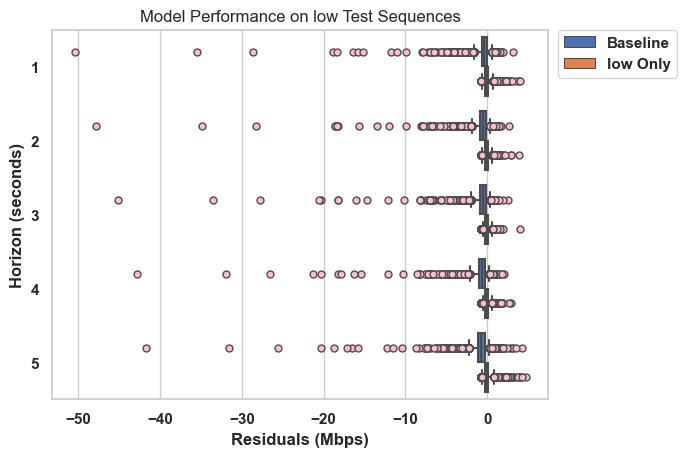

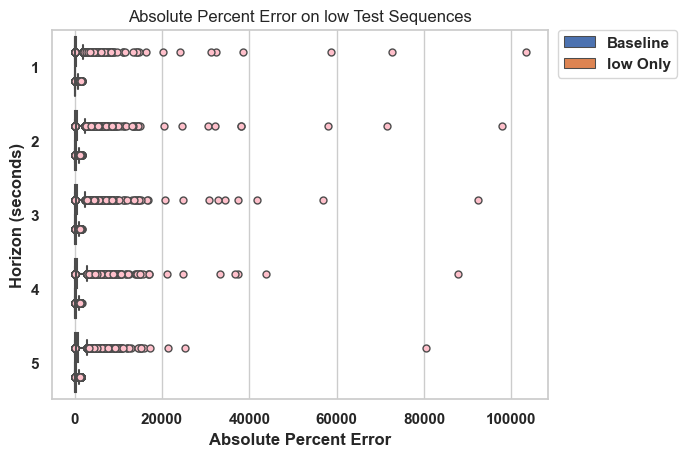

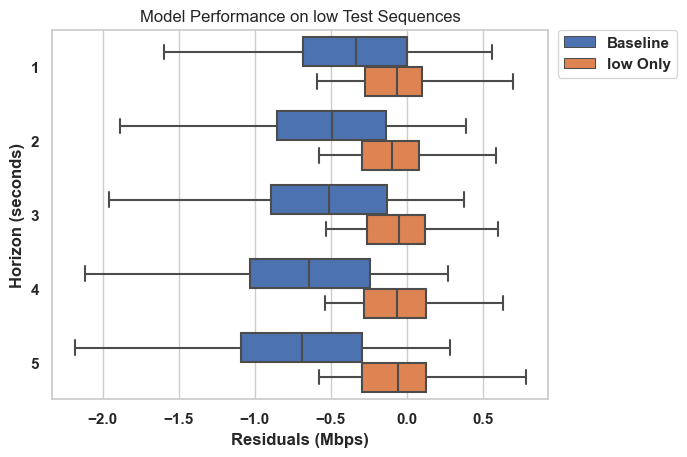

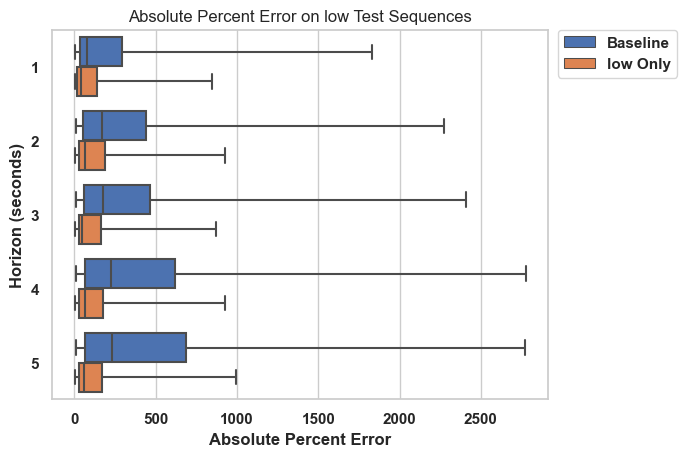

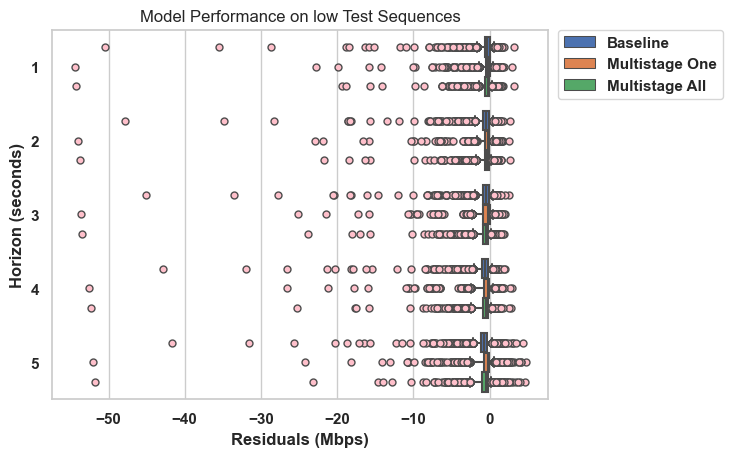

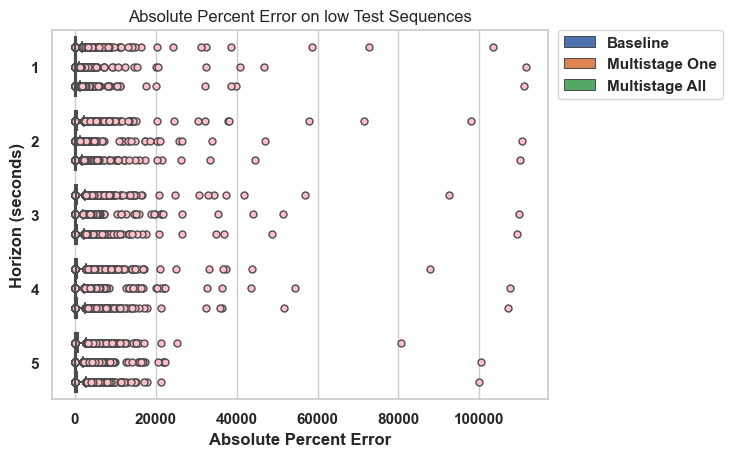

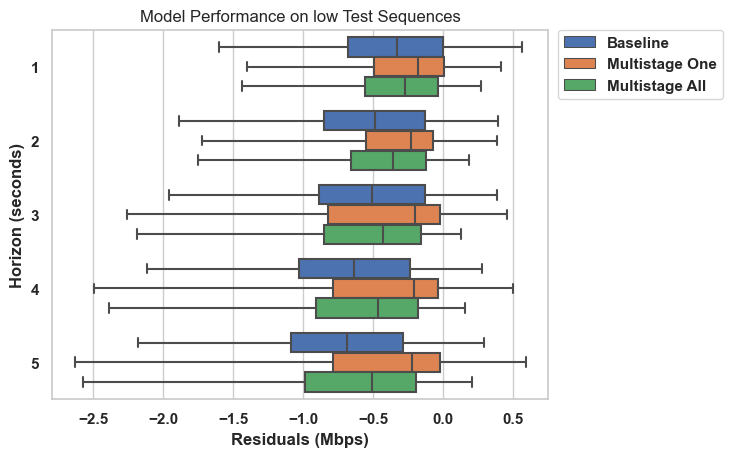

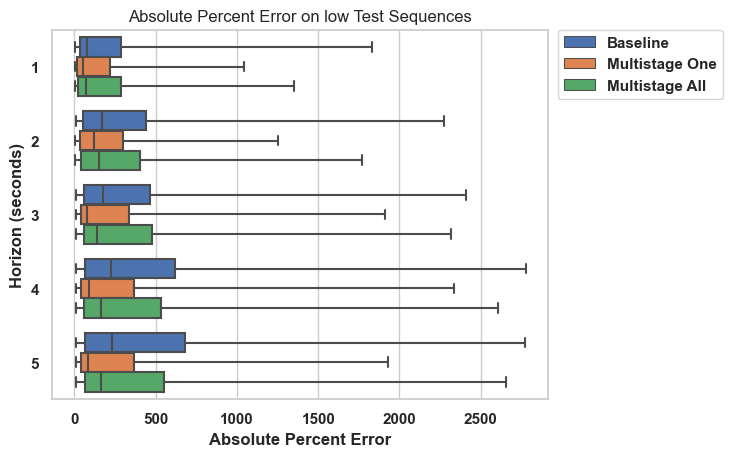

Residuals of low Sequences Test Set
\begin{table}[!htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\
\hline
Baseline & -0.672 & 1.425 & 674.087 & 2.482 & 0.777\\
\hline
low Only & -0.042 & 0.396 & 185.417 & 0.159 & 0.285\\
\hline
\end{tabular}
\label{tab:train_test_dist}
\end{table}


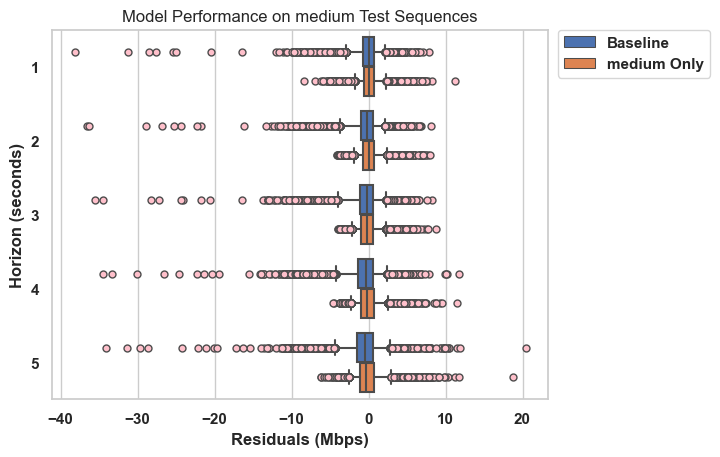

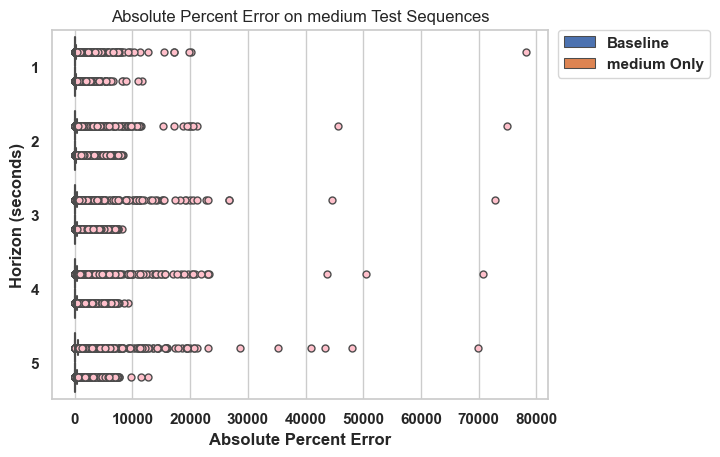

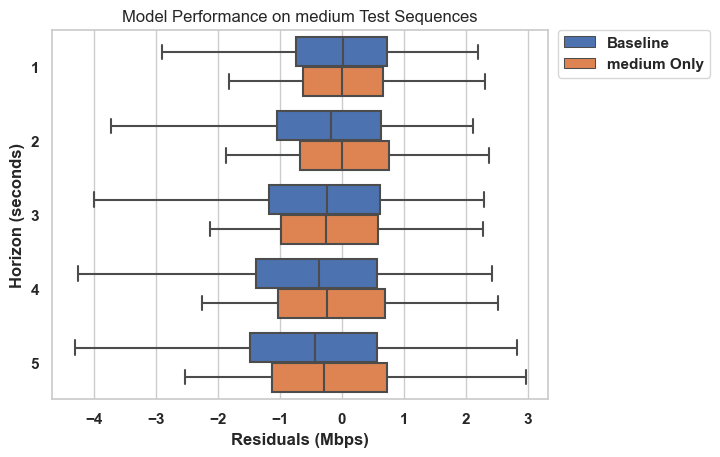

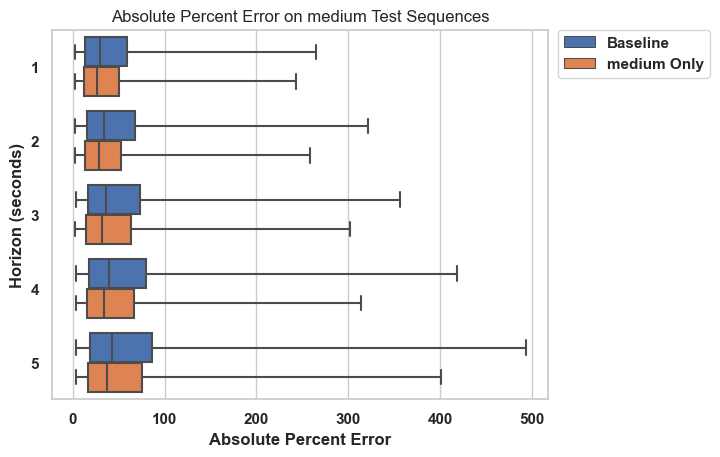

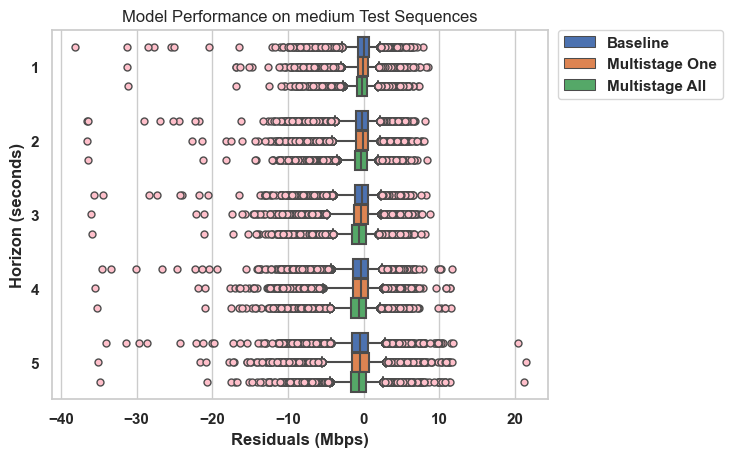

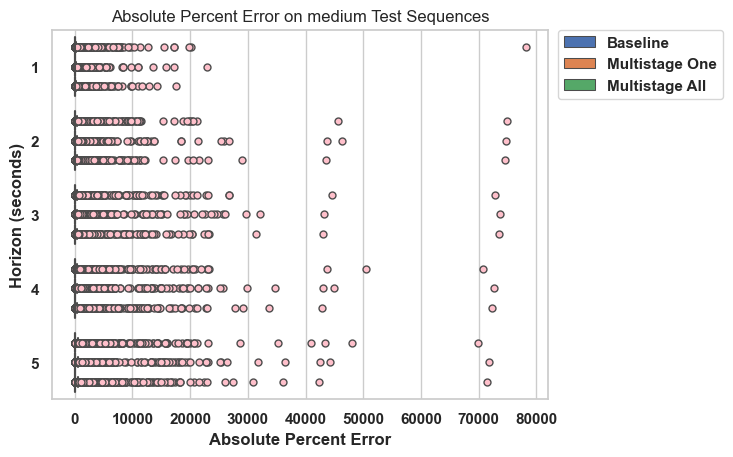

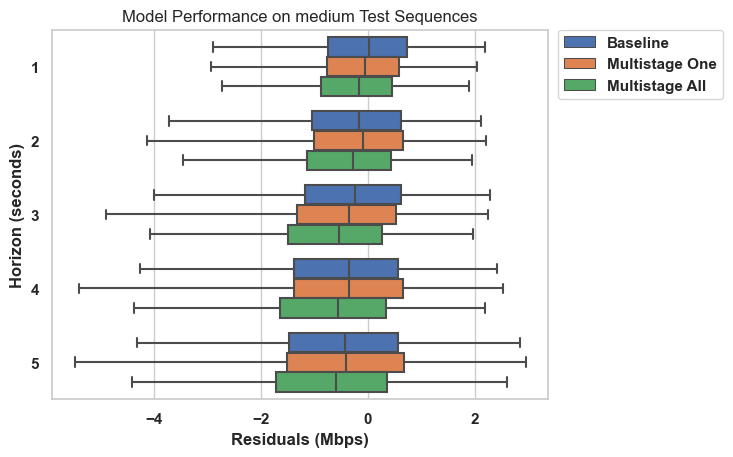

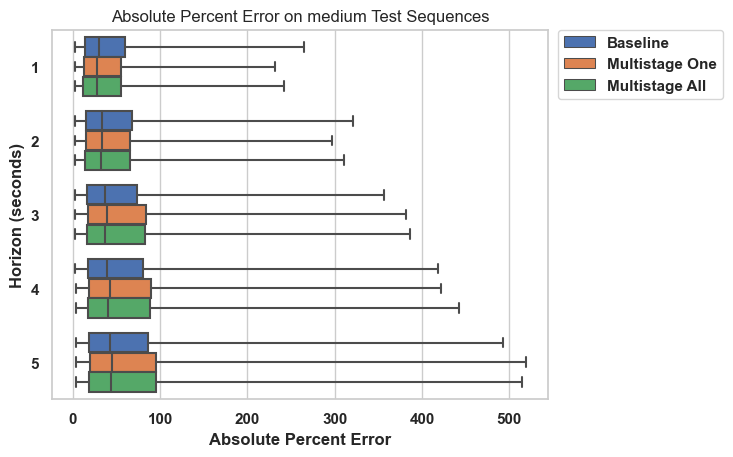

Residuals of medium Sequences Test Set
\begin{table}[!htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\
\hline
Baseline & -0.436 & 2.171 & 198.599 & 4.903 & 1.386\\
\hline
medium Only & -0.03 & 1.44 & 133.215 & 2.074 & 1.061\\
\hline
\end{tabular}
\label{tab:train_test_dist}
\end{table}


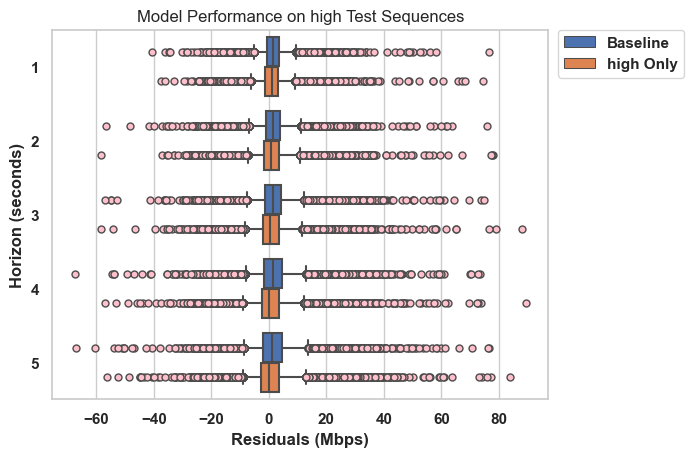

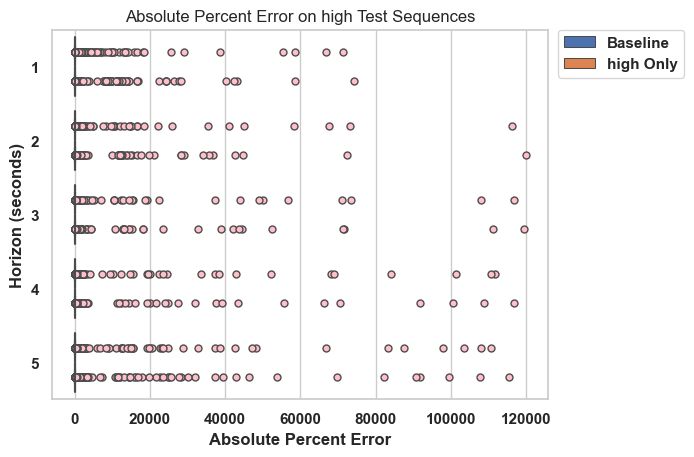

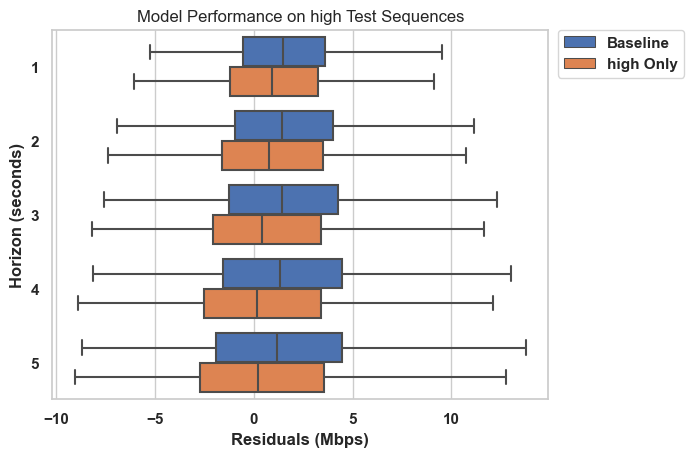

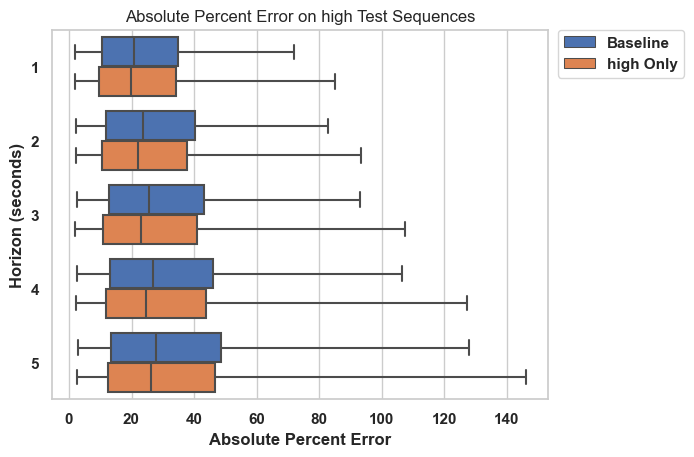

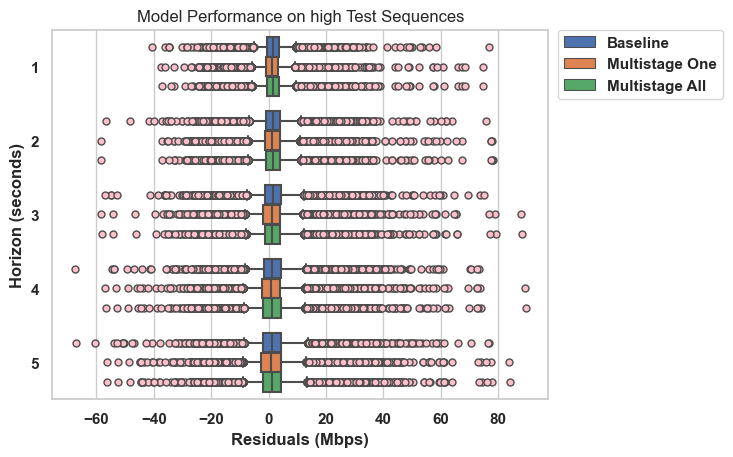

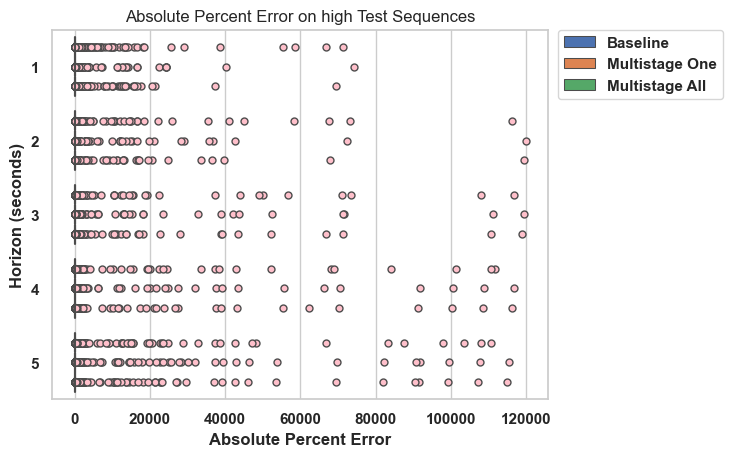

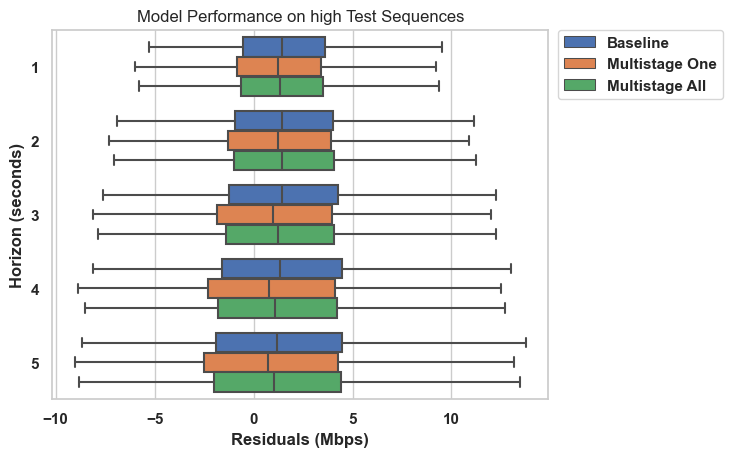

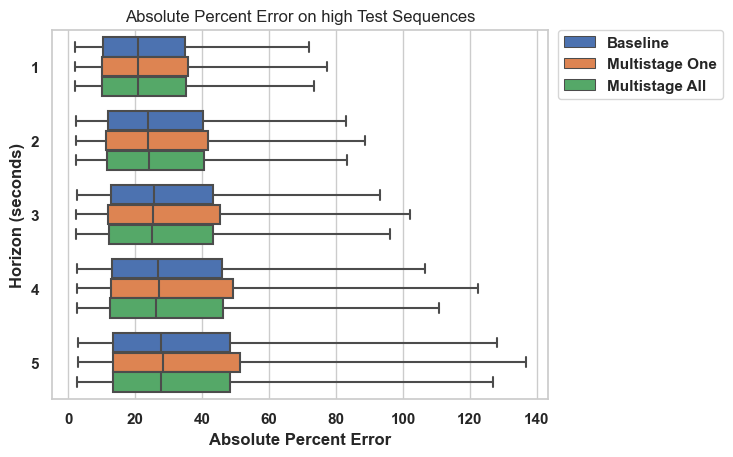

Residuals of high Sequences Test Set
\begin{table}[!htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\
\hline
Baseline & 1.735 & 6.587 & 97.855 & 46.398 & 4.432\\
\hline
high Only & 0.991 & 6.636 & 104.708 & 45.015 & 4.281\\
\hline
\end{tabular}
\label{tab:train_test_dist}
\end{table}


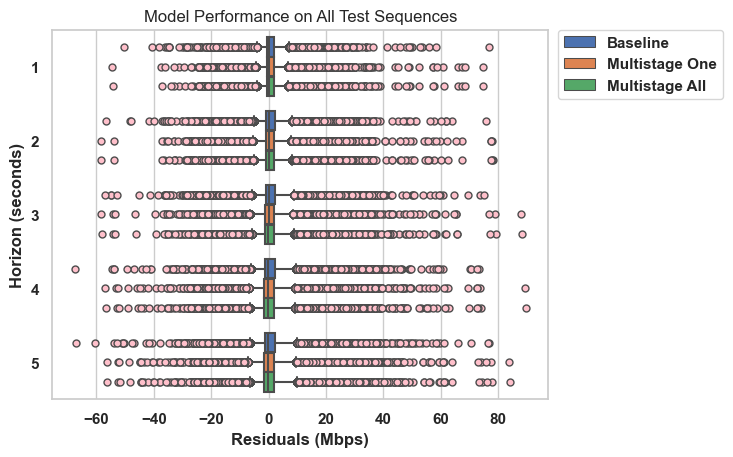

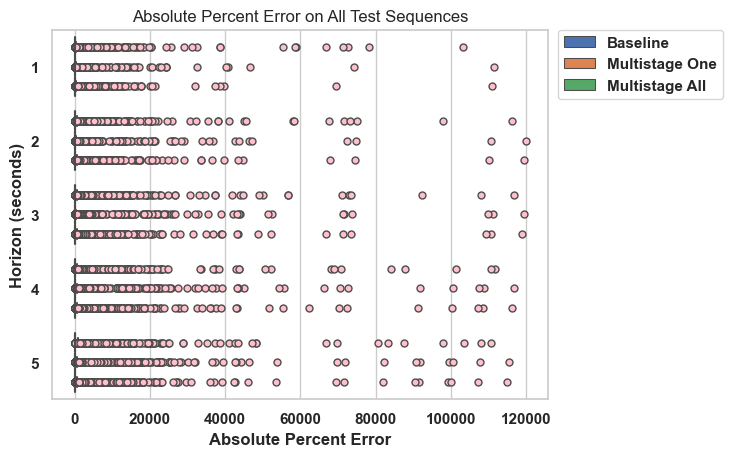

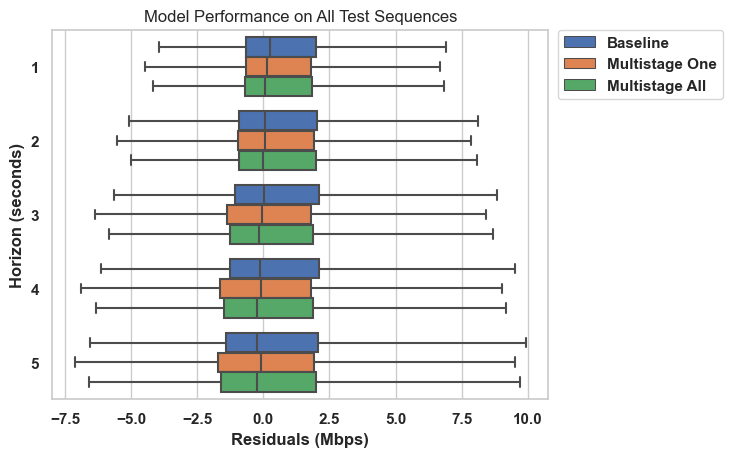

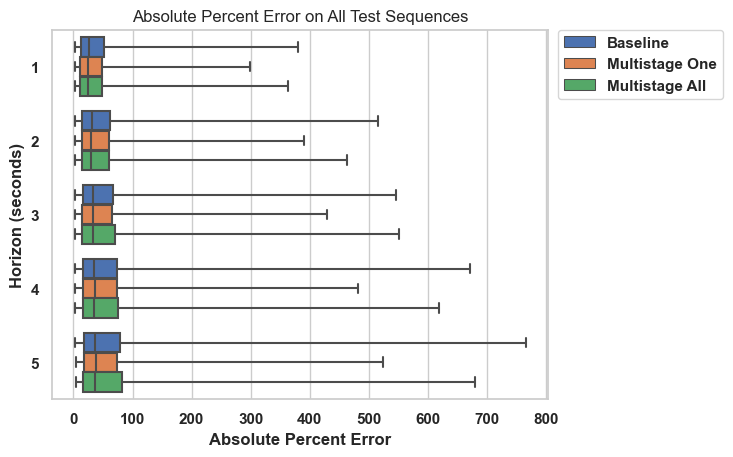

Residuals of All Sequences Test Set
\begin{table}[!htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\
\hline
Baseline & 0.7 & 5.145 & 221.605 & 26.966 & 2.935\\
\hline
Multistage One & 0.505 & 5.212 & 184.644 & 27.421 & 2.942\\
\hline
Multistage All & 0.583 & 5.18 & 196.031 & 27.169 & 2.915\\
\hline
\end{tabular}
\label{tab:train_test_dist}
\end{table}
Classification Report:
               precision    recall  f1-score   support

         low       0.83      0.71      0.77      4417
      medium       0.70      0.78      0.74      8011
        high       0.92      0.90      0.91     14661

    accuracy                           0.83     27089
   macro avg       0.82      0.80      0.80     27089
weighted avg       0.84      0.83      0.83     27089



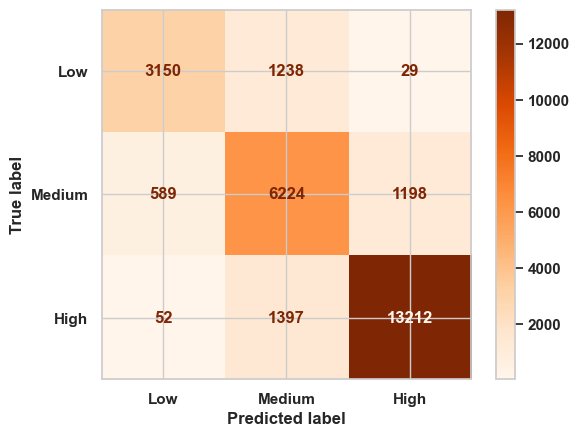

In [85]:
carry_out_analysis("std_all", "All Data")

In [ ]:
carry_out_analysis("std_all_up", "Upsampling")

In [ ]:
carry_out_analysis("H15H5", "H15H5")

# Individual Models

In [72]:
true, pred = import_data("std_all_baseline")
base_balanced = get_ts_residuals(true, pred, False)
mape_balanced = get_mape(true, pred)
ape_balanced = get_ape(true, pred)

print(true[1]-pred[1])
true = true/1024
pred = pred/1024
print(true[1]-pred[1])
# true, pred = import_data("pca_selected_baseline")
# base = get_ts_residuals(true, pred)
# mape = get_mape(true, pred)
# ape = get_ape(true, pred)

# time_step_boxplots([base, base_balanced], model_names=["Baseline", "Balanced Baseline"], title="Balanced vs Unbalanced")
# time_step_boxplots([ape, ape_balanced], model_names=["Baseline", "Balanced Baseline"], title="Balanced vs Unbalanced", xlab="Absolute Percent Error")

[10377.46123389 -2109.49647197 -1129.29706792   794.26687029
  1291.86979264]
[10.13423949 -2.06005515 -1.10282917  0.77565124  1.26159159]


In [ ]:
true, pred = import_data("solo_low_all_network")
low = compute_residuals(true, pred)
low_ts = get_ts_residuals(true, pred)
true, pred = import_data("standard_4_all_network_baseline_low")
base_low = compute_residuals(true, pred)
base_low_ts = get_ts_residuals(true, pred)
generate_boxplot(datasets=[base_low, low], xlab=["Baseline", "Low Only"], title="Model Performance on Low Test Sequences", ylim=(-5,5))

In [ ]:
generate_boxplot(datasets=[base_low, low], xlab=["Baseline", "Low Only"], title="Model Performance on Low Test Sequences")

In [ ]:
time_step_boxplots([base_low_ts, low_ts], model_names=["Baseline", "Low Only"], xlim=(-5,5), title="Model Performance on Low Test Sequences")

In [ ]:
base_std = get_std(base_low)
low_std = get_std(low)
table_low = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)"])
table_low.add_row(["Baseline", np.mean(base_low_ts), np.std(base_low_ts)])
table_low.add_row(["Low Only Model", np.mean(low_ts), np.std(low_ts)])
print("Residuals of Low Sequences Test Set")
print(table_low)

In [ ]:
true, pred = import_data("solo_medium_all_network")
medium = compute_residuals(true, pred)
medium_ts = get_ts_residuals(true, pred)
true, pred = import_data("standard_4_all_network_baseline_medium")
base_medium = compute_residuals(true, pred)
base_medium_ts = get_ts_residuals(true, pred)
generate_boxplot(datasets=[base_medium, medium], xlab=["Baseline", "Medium Only"], title="Model Performance on Medium Test Sequences", ylim=(-25,15))

In [ ]:
time_step_boxplots([base_medium_ts, medium_ts], model_names=["Baseline", "Medium Only"], title="Model Performance on Medium Test Sequences")


In [ ]:
base_std = get_std(base_medium_ts)
medium_std = get_std(medium_ts)
table_medium = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)"])
table_medium.add_row(["Baseline",np.mean(base_medium_ts), base_std])
table_medium.add_row(["Medium Only Model",np.mean(medium_ts), medium_std])
print("Residuals of Medium Sequences Test Set")
print(table_medium)

In [ ]:
true, pred = import_data("solo_high_all_network")
high = compute_residuals(true, pred)
high_ts = get_ts_residuals(true, pred)
true, pred = import_data("standard_4_all_network_baseline_high")
base_high = compute_residuals(true, pred)
base_high_ts = get_ts_residuals(true, pred)
generate_boxplot(datasets=[base_high, high], xlab=["Baseline", "High Only"], title="Model Performance on High Test Sequences", ylim=(-40, 40))

In [ ]:
time_step_boxplots([base_high_ts, high_ts], model_names=["Baseline", "High Only"], title="Model Performance on High Test Sequences")


In [ ]:
base_std = get_std(base_high_ts)
high_std = get_std(high_ts)
table_high = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)"])
table_high.add_row(["Baseline",np.mean(base_high_ts), base_std])
table_high.add_row(["High Only Model",np.mean(high_ts), high_std])
print("Residuals of High Sequences Test Set")
print(table_high)

In [ ]:
true, pred = import_data("standardized_multiOne")
multi_one_ts = get_ts_residuals(true, pred)
multi_one_mape = get_mape(true, pred)

true, pred = import_data("standardized_multiAll")
multi_all_ts = get_ts_residuals(true, pred)
multi_all_mape = get_mape(true, pred)

true, pred = import_data("standard_4_all_network_baseline")
base_ts = get_ts_residuals(true, pred)
base_mape = get_mape(true, pred)
# generate_boxplot(datasets=[base, multi_one, multi_all], xlab=["Baseline", "Multistage One", "Multistage All"], title="Model Performance on All Test Sequences")
# generate_boxplot(datasets=[base, multi_one], xlab=["Baseline", "Multistage One"], title="Model Performance on all Test Sequences")

In [ ]:
base_std = get_std(base_ts)
multi_one_std = get_std(multi_one_ts)
multi_all_std = get_std(multi_all_ts)
table = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)", "MAPE"])
table.add_row(["Baseline",np.mean(base_ts), base_std, base_mape])
table.add_row(["Multistage One",np.mean(multi_one_ts), multi_one_std, multi_one_mape])
table.add_row(["Multistage All",np.mean(multi_all_ts), multi_all_std, multi_all_mape])
print("Residuals of All Sequences Test Set")
print(table)

In [ ]:
time_step_boxplots([base_ts, multi_one_ts, multi_all_ts], model_names=["Baseline", "Multistage One", "Multistage All"], title="Model Performance on All Test Sequences", xlim=(-80, 200))


In [ ]:
true, pred = import_data("presentation_2_multiOne")
multi_one_ts = get_ts_residuals(true, pred)
multi_one_mape = get_mape(true, pred)

true, pred = import_data("presentation_2_multiAll")
multi_all_ts = get_ts_residuals(true, pred)
multi_all_mape = get_mape(true, pred)

true_low, pred_low = import_data("standard_4_all_network_baseline_low")
true_low = np.squeeze(true_low)
true_medium, pred_medium = import_data("standard_4_all_network_baseline_medium")
true_medium = np.squeeze(true_medium)
true = np.zeros((len(true_low)+len(true_medium), true_low.shape[1]))
pred = np.zeros((len(pred_low)+len(pred_medium), pred_low.shape[1]))


true[:len(true_low),:] = true_low
true[len(true_low):,:] = true_medium
pred[:len(pred_low),:] = pred_low
pred[len(pred_low):,:] = pred_medium

base_mape = get_mape(true, pred)
base_ts = get_ts_residuals(true, pred)
time_step_boxplots([base_ts, multi_one_ts, multi_all_ts], model_names=["Baseline", "Multistage One", "Multistage All"], title="Model Performance on Med&Low Test Sequences", xlim=(-50,44))


In [ ]:
base_std = get_std(base_ts)
multi_one_std = get_std(multi_one_ts)
multi_all_std = get_std(multi_all_ts)
table = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)", "MAPE"])
table.add_row(["Baseline",np.mean(base), base_std, base_mape])
table.add_row(["Multistage One",np.mean(multi_one), multi_one_std, multi_one_mape])
table.add_row(["Multistage All",np.mean(multi_all), multi_all_std, multi_all_mape])
print("Residuals of Med & Low Sequences Test Set")
print(table)

In [ ]:
print("Residuals of Low Sequences Test Set")
print(table_low)
print("==============================================================\n")
print("Residuals of Medium Sequences Test Set")
print(table_medium)
print("==============================================================\n")
print("Residuals of High Sequences Test Set")
print(table_high)
print("==============================================================")

In [ ]:
true, pred = import_data("solo_all_network_classifier")
print(true)
print(pred)
pred = np.argmax(pred, axis=-1)
print(pred)
conf_matrix = confusion_matrix(true, pred)
display_conf = ConfusionMatrixDisplay(conf_matrix, display_labels=["Low", "Medium", "High"])
display_conf.plot(cmap="Oranges")
plt.show()

In [ ]:
carry_out_analysis(prefix="presentation")